In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
from adaline import AdalineSGD

# load data and preprocessing

In [8]:
dataset_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(dataset_link,
                header=None,
                encoding='utf-8')
print(df.shape)
df.head()

(150, 5)


,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## feature selection

In [9]:
X = df.iloc[0:100, [0, 2]].values
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)
X.shape, y.shape

((100, 2), (100,))

## feature scaling, normalization (use standardization)

In [143]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# model

In [174]:
class AdalineSGD:
	def __init__(self, eta=0.01, n_iter=20, random_state=1, shuffle=True, initilized_weight=False):
		self.eta = eta
		self.n_iter = n_iter
		self.random_state = random_state
		self.shuffle = shuffle
		self.initilized_weight = initilized_weight
	def fit(self, X, y):
		self._initilize_weight(X.shape[1])
		self.losses_ = list()
		for _ in range(self.n_iter):
			if self.shuffle:
				X, y = self._shuffle(X, y)
			losses = list()
			for xi, yi in zip(X, y):
				loss = self._update_weight(xi, yi)
				losses.append(loss)
			self.losses_.append(np.mean(losses))

	def partial_fit(self, X, y):
		if not self.initilized_weight:
			self._initilize_weight(X.shape[1])
		if y.ravel().shape[0] > 1:
			for xi, yi in zip(X, y):
				self._update_weight(xi, yi)
		else:
			self._update_weight(X, y)
	def _initilize_weight(self, d):
		self.rgen = np.random.RandomState(self.random_state)
		self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=d)
		self.b_ = np.float_(0.0)
		self.initilized_weight = True
	def _shuffle(self, X, y):
		idx = self.rgen.permutation(y.shape[0])
		return X[idx], y[idx]
	def _update_weight(self, xi, yi):
		net_input = self.net_input(xi)
		calculated_output = self.activation(net_input)
		error = (yi - calculated_output)
		update = 2 * self.eta * error
		self.w_ += xi * update
		self.b_ += update
		loss = error ** 2
		return loss

	def predict(self, X):
		calculated_output = self.activation(self.net_input(X))
		return np.where(calculated_output >= 0.5, 1, 0)
	def net_input(self, x):
		return np.dot(x, self.w_) + self.b_
	def activation(self, z):
		return z

# Training

## without standardization technique

In [134]:
predictive_model = AdalineSGD(eta=0.01, n_iter=20, random_state=1, shuffle=True)

In [135]:
predictive_model.fit(X, y)

## with standardization 

In [175]:
predictive_model_with_std_X = AdalineSGD(eta=0.01, n_iter=20, random_state=1, shuffle=True)
predictive_model_with_std_X.fit(X_std, y)

## online learning, iteractive learning

In [176]:
idx = np.random.permutation(10)
predictive_model_with_std_X.partial_fit(X[idx[0], :], y[idx[0]])

In [177]:
idx = np.random.permutation(10)
predictive_model_with_std_X.partial_fit(X[idx[0:5], :], y[idx[0:5]])

# evaluation

## classification accuracy

In [137]:
(predictive_model.predict(X) == y).sum() / y.shape[0]

1.0

# visualization

In [138]:
from matplotlib.colors import ListedColormap
def plot_desicion_boundary(X, y, classifier):
    colors = ('red', 'blue', 'green', 'black')
    cmap = ListedColormap(colors[0:len(np.unique(y))])
    markers = ['o', 's', '^', '<']
    resolution = 0.02
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    xx1, xx2 = np.meshgrid(np.arange(x1_min - 1, x1_max + 1, resolution),
                            np.arange(x2_min - 1, x2_max + 1, resolution))
    labels = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    labels = labels.reshape(xx1.shape)
    plt.contourf(xx1, xx2, labels, cmap=cmap, alpha=0.2)

    for idx, class_ in enumerate(np.unique(y)):
        plt.scatter(X[y == class_, 0], X[y == class_, 1], color = colors[idx],
                    marker = markers[idx],
                   edgecolor='black')

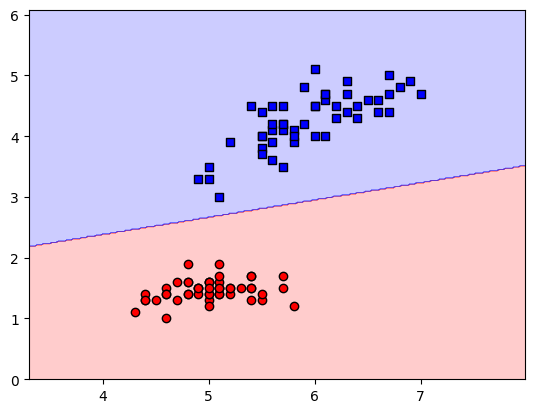

In [139]:
plot_desicion_boundary(X, y, predictive_model)

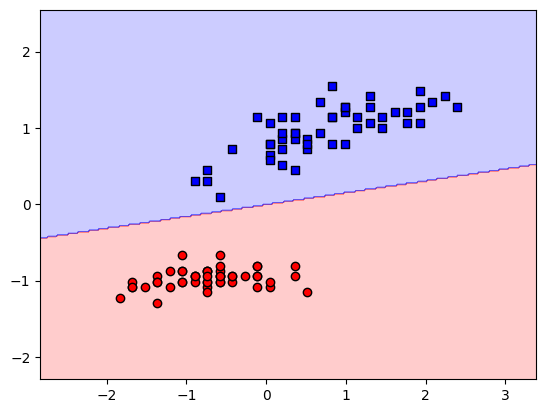

In [158]:
plot_desicion_boundary(X_std, y, predictive_model_with_std_X)

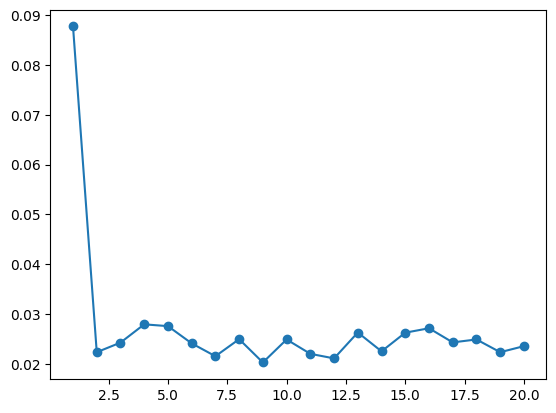

In [140]:
plt.plot(range(1, len(predictive_model.losses_) + 1), predictive_model.losses_, marker='o')

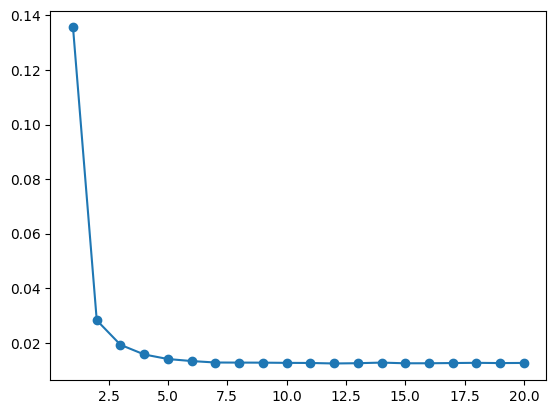

In [156]:
plt.plot(range(1, len(predictive_model_with_std_X.losses_) + 1), predictive_model_with_std_X.losses_, marker='o')

In [ ]:
# nhận xét: feature scaling giúp quá trình gradient descent dễ dàng hơn, lựa chọn learning rate dễ dàng hơn, bởi vì nếu không scale lại thì 
# learning rate có thể phù hợp với feature này nhưng lại quá lớn, quá nhỏ so với features khác
# khởi tạo trọng số không nên khởi tạo bằng 0
# sử dụng activation là identity function thay vì unit step function giúp hàm loss trờ nên diferentiable